In [14]:
import numpy as np
import pandas as pd

def detect_events_tail(
    df, D_col="D_s",
    mode="high",          # "high" or "low"
    q_enter=0.90,
    q_exit=0.70,
    min_on=3,
    min_off=3
):
    """
    mode="high": enter when D > tau_enter (q_enter), exit when D < tau_exit (q_exit)
    mode="low" : enter when D < tau_enter (q_enter), exit when D > tau_exit (q_exit)
                 (여기서 tau_enter는 하위 q_enter 분위수, tau_exit는 하위 q_exit 분위수로 잡힘)
    """
    if mode not in ("high", "low"):
        raise ValueError("mode must be 'high' or 'low'")

    if mode == "high":
        tau_enter = float(df[D_col].quantile(q_enter))
        tau_exit  = float(df[D_col].quantile(q_exit))

        on_cond  = df[D_col] > tau_enter
        off_cond = df[D_col] < tau_exit

    else:  # mode == "low"
        # 하위 꼬리: enter는 하위 10% 이하, exit는 하위 30% 위로 회복 등으로 해석
        tau_enter = float(df[D_col].quantile(1.0 - q_enter))  # e.g., 0.10
        tau_exit  = float(df[D_col].quantile(1.0 - q_exit))   # e.g., 0.30

        on_cond  = df[D_col] < tau_enter
        off_cond = df[D_col] > tau_exit

    on_k  = (on_cond.rolling(min_on).sum() >= min_on)
    off_k = (off_cond.rolling(min_off).sum() >= min_off)

    events = []
    state = 0
    start_idx = None

    for i in range(len(df)):
        if state == 0:
            if bool(on_k.iloc[i]):
                start_idx = i - min_on + 1
                state = 1
        else:
            if bool(off_k.iloc[i]):
                resolve_idx = i - min_off + 1
                events.append((start_idx, resolve_idx))
                state = 0
                start_idx = None

    return {
        "mode": mode,
        "tau_enter": tau_enter,
        "tau_exit": tau_exit,
        "events": events
    }
    
def forward_metrics_diff_2d(df, starts, F_col="fin_index", R_col="real_index", horizon=12):
    out = []
    for s in starts:
        if s + horizon >= len(df):
            continue
        seg = df.iloc[s:s+horizon+1]

        F0 = float(seg[F_col].iloc[0])
        R0 = float(seg[R_col].iloc[0])

        Farr = seg[F_col].to_numpy()
        Rarr = seg[R_col].to_numpy()

        out.append({
            "start_date": seg["date"].iloc[0],
            "F_fwd_diff": float(Farr[-1] - F0),
            "F_min_diff": float(Farr.min() - F0),
            "R_fwd_diff": float(Rarr[-1] - R0),
            "R_min_diff": float(Rarr.min() - R0),
        })
    return pd.DataFrame(out)


[HIGH] events=3 | tau_enter=0.825759 | tau_exit=0.479439
high periods: [(datetime.date(2005, 1, 1), datetime.date(2005, 10, 1)), (datetime.date(2020, 11, 1), datetime.date(2021, 3, 1)), (datetime.date(2024, 9, 1), datetime.date(2025, 2, 1))]

[LOW ] events=2 | tau_enter=-1.060468 | tau_exit=-0.287196
low  periods: [(datetime.date(2008, 2, 1), datetime.date(2009, 8, 1)), (datetime.date(2022, 5, 1), datetime.date(2023, 4, 1))]

[HIGH tail] mean F_min_diff: -0.3016923273521383
[HIGH tail] mean R_min_diff: -0.26057727280853465
[HIGH tail] mean F_fwd_diff: 0.0977051665651661
[HIGH tail] mean R_fwd_diff: 1.6889562271326406

[LOW  tail] mean F_min_diff: -2.3761931409142205
[LOW  tail] mean R_min_diff: -2.5178455377379567
[LOW  tail] mean F_fwd_diff: -1.500570302729854
[LOW  tail] mean R_fwd_diff: -2.186551038957746


,start_date,F_fwd_diff,F_min_diff,R_fwd_diff,R_min_diff
0,2005-01-01,0.110680,-0.074095,2.106100,0.000000
1,2020-11-01,0.147165,0.000000,2.058884,-0.580925
2,2024-09-01,0.035270,-0.830982,0.901884,-0.200807


,start_date,F_fwd_diff,F_min_diff,R_fwd_diff,R_min_diff
0,2008-02-01,-3.377083,-3.908687,-2.823358,-3.198462
1,2022-05-01,0.375943,-0.843699,-1.549744,-1.837229


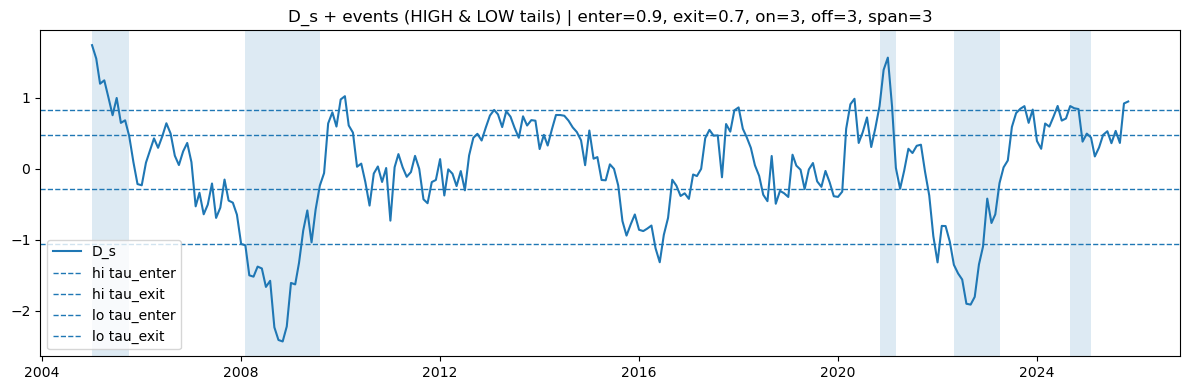

In [16]:
import matplotlib.pyplot as plt

# -----------------------
# Load + smoothing
# -----------------------
CSV_PATH = "data/decoupling.csv"
df = pd.read_csv(CSV_PATH)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

F_COL = "fin_index"
R_COL = "real_index"
D_RAW = "gap"

SMOOTH_SPAN = 3
df["D_s"] = df[D_RAW].ewm(span=SMOOTH_SPAN, adjust=False).mean()

# -----------------------
# params
# -----------------------
Q_ENTER = 0.90
Q_EXIT  = 0.70
MIN_ON  = 3
MIN_OFF = 3
H = 12

# -----------------------
# detect both tails
# -----------------------
hi = detect_events_tail(df, "D_s", mode="high", q_enter=Q_ENTER, q_exit=Q_EXIT, min_on=MIN_ON, min_off=MIN_OFF)
lo = detect_events_tail(df, "D_s", mode="low",  q_enter=Q_ENTER, q_exit=Q_EXIT, min_on=MIN_ON, min_off=MIN_OFF)

hi_starts = [s for s,_ in hi["events"]]
lo_starts = [s for s,_ in lo["events"]]

print(f"[HIGH] events={len(hi['events'])} | tau_enter={hi['tau_enter']:.6f} | tau_exit={hi['tau_exit']:.6f}")
print("high periods:", [(df.loc[s,'date'].date(), df.loc[e,'date'].date()) for s,e in hi["events"]])

print(f"\n[LOW ] events={len(lo['events'])} | tau_enter={lo['tau_enter']:.6f} | tau_exit={lo['tau_exit']:.6f}")
print("low  periods:", [(df.loc[s,'date'].date(), df.loc[e,'date'].date()) for s,e in lo["events"]])

# -----------------------
# forward metrics: finance vs real
# -----------------------
hi_m = forward_metrics_diff_2d(df, hi_starts, F_col=F_COL, R_col=R_COL, horizon=H)
lo_m = forward_metrics_diff_2d(df, lo_starts, F_col=F_COL, R_col=R_COL, horizon=H)

print("\n[HIGH tail] mean F_min_diff:", hi_m["F_min_diff"].mean() if len(hi_m) else np.nan)
print("[HIGH tail] mean R_min_diff:", hi_m["R_min_diff"].mean() if len(hi_m) else np.nan)
print("[HIGH tail] mean F_fwd_diff:", hi_m["F_fwd_diff"].mean() if len(hi_m) else np.nan)
print("[HIGH tail] mean R_fwd_diff:", hi_m["R_fwd_diff"].mean() if len(hi_m) else np.nan)

print("\n[LOW  tail] mean F_min_diff:", lo_m["F_min_diff"].mean() if len(lo_m) else np.nan)
print("[LOW  tail] mean R_min_diff:", lo_m["R_min_diff"].mean() if len(lo_m) else np.nan)
print("[LOW  tail] mean F_fwd_diff:", lo_m["F_fwd_diff"].mean() if len(lo_m) else np.nan)
print("[LOW  tail] mean R_fwd_diff:", lo_m["R_fwd_diff"].mean() if len(lo_m) else np.nan)

display(hi_m)
display(lo_m)

# -----------------------
# visualization: D_s + both tails
# -----------------------
plt.figure(figsize=(12,4))
plt.plot(df["date"], df["D_s"], label="D_s")

# thresholds lines
plt.axhline(hi["tau_enter"], linestyle="--", linewidth=1, label="hi tau_enter")
plt.axhline(hi["tau_exit"],  linestyle="--", linewidth=1, label="hi tau_exit")
plt.axhline(lo["tau_enter"], linestyle="--", linewidth=1, label="lo tau_enter")
plt.axhline(lo["tau_exit"],  linestyle="--", linewidth=1, label="lo tau_exit")

# spans
for (s,e) in hi["events"]:
    plt.axvspan(df.loc[s,"date"], df.loc[e,"date"], alpha=0.15)
for (s,e) in lo["events"]:
    plt.axvspan(df.loc[s,"date"], df.loc[e,"date"], alpha=0.15)

plt.title(f"D_s + events (HIGH & LOW tails) | enter={Q_ENTER}, exit={Q_EXIT}, on={MIN_ON}, off={MIN_OFF}, span={SMOOTH_SPAN}")
plt.legend()
plt.tight_layout()
plt.savefig('해소가설.png')
plt.show()
